1. null 체크 --> 3개 열에서 missing이 많음 (ps_reg_03, ps_car_03_cat, ps_car_05_cat)
2. 종속변수 밸런스 체크 --> imbalanced (0 : 1 = 96% : 4%)
3. 독립변수들 간의 상관관계 체크 
    --> float열 : 대부분 0. 
        강한 상관관계 : (ps_reg_01, ps_reg_03)  
                        (ps_reg_02, ps_reg_03)  
                        (ps_car_12, ps_car_13)
                        (ps_car_13, ps_car_15)
    --> int열 : 대부분 0
        음수인 상관관계도 있음 : ps_ind_06_bin, ps_ind_07_bin, ps_ind_08_bin, ps_ind_09_bin
        
4. 독립변수와 종속변수 간 종속성 체크
5. 이진변수 분포 체크
6. 범주형 변수 중요도 체크
    - RandomForest
    - Decision Tree
    - Gradient Boosting


In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import seaborn as sns
import plotly.graph_objs as go
import plotly.tools as tls
import warnings
from collections import Counter
from sklearn.feature_selection import mutual_info_classif
warnings.filterwarnings('ignore')
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

In [2]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
train.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.7,0.2,0.718070,10,1,-1,0,1,4,1,0,0,1,12,2,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.8,0.4,0.766078,11,1,-1,0,-1,11,1,1,2,1,19,3,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.0,0.0,-1.000000,7,1,-1,0,-1,14,1,1,2,1,60,1,0.316228,0.641586,0.347275,3.316625,0.5,0.7,0.1,2,2,9,1,8,2,7,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.9,0.2,0.580948,7,1,0,0,1,11,1,1,3,1,104,1,0.374166,0.542949,0.294958,2.000000,0.6,0.9,0.1,2,4,7,1,8,4,2,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.7,0.6,0.840759,11,1,-1,0,-1,14,1,1,2,1,82,3,0.316070,0.565832,0.365103,2.000000,0.4,0.6,0.0,2,2,6,3,10,2,12,3,1,1,3,0,0,0,1,1,0


In [ ]:
train.shape

### check duplicate rows
pandas.DataFrame.drop_duplicates : Return DataFrame with duplicate rows removed.

In [6]:
train.drop_duplicates().shape # default : inplace=False. 

(595212, 59)

No duplicate rows, so that's fine

In [7]:
test.shape

(892816, 58)

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 59 columns):
id                595212 non-null int64
target            595212 non-null int64
ps_ind_01         595212 non-null int64
ps_ind_02_cat     595212 non-null int64
ps_ind_03         595212 non-null int64
ps_ind_04_cat     595212 non-null int64
ps_ind_05_cat     595212 non-null int64
ps_ind_06_bin     595212 non-null int64
ps_ind_07_bin     595212 non-null int64
ps_ind_08_bin     595212 non-null int64
ps_ind_09_bin     595212 non-null int64
ps_ind_10_bin     595212 non-null int64
ps_ind_11_bin     595212 non-null int64
ps_ind_12_bin     595212 non-null int64
ps_ind_13_bin     595212 non-null int64
ps_ind_14         595212 non-null int64
ps_ind_15         595212 non-null int64
ps_ind_16_bin     595212 non-null int64
ps_ind_17_bin     595212 non-null int64
ps_ind_18_bin     595212 non-null int64
ps_reg_01         595212 non-null float64
ps_reg_02         595212 non-null float64
ps_re

In [9]:
from collections import Counter
Counter(train.dtypes.values)

Counter({dtype('int64'): 49, dtype('float64'): 10})

**Metadata**

In [10]:
data = []
for f in train.columns:
    # Defining the role
    if f == 'target':
        role = 'target'
    elif f == 'id':
        role = 'id'
    else:
        role = 'input'
        
    # Defining the level
    if 'bin' in f or f == 'target':
        level = 'binary'
    elif 'cat' in f or f =='id':
        level = 'nominal'
    elif train[f].dtype == float:
        level = 'interval'
    elif train[f].dtype == int:
        level = 'ordinal'
        
    # Initialize keep to True for all variables except for id
    keep = True
    if f == 'id':
        keep = False
        
    # Defining the data type
    dtype = train[f].dtype
    
    # Creating a Dcit that contains all the metadata for the variable
    f_dict = {
        'varname':f,
        'role':role,
        'level':level,
        'keep':keep,
        'dtype':dtype
    }
    data.append(f_dict)
    
meta = pd.DataFrame(data, columns=['varname','role','level','keep','dtype'])
meta.set_index('varname',inplace=True)    

In [11]:
meta

,role,level,keep,dtype
varname,,,,
id,id,nominal,False,int64
target,target,binary,True,int64
ps_ind_01,input,ordinal,True,int64
ps_ind_02_cat,input,nominal,True,int64
ps_ind_03,input,ordinal,True,int64
ps_ind_04_cat,input,nominal,True,int64
ps_ind_05_cat,input,nominal,True,int64
ps_ind_06_bin,input,binary,True,int64
ps_ind_07_bin,input,binary,True,int64


Example to extract all nomial variables that are not dropped

In [12]:
meta[(meta.level=='nominal')&(meta.keep)].index

Index(['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat',
       'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat',
       'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat',
       'ps_car_10_cat', 'ps_car_11_cat'],
      dtype='object', name='varname')

In [13]:
pd.DataFrame({'count':meta.groupby(['role','level'])['role'].size()}).reset_index()

,role,level,count
0,id,nominal,1
1,input,binary,17
2,input,interval,10
3,input,nominal,14
4,input,ordinal,16
5,target,binary,1


### Descriptive statistics

To keep things clear, we'll do this per data type  
**Interval variables**

In [14]:
v = meta[(meta.level == 'interval')&(meta.keep)].index
train[v].describe()

,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.610991,0.439184,0.551102,0.379945,0.813265,0.276256,3.065899,0.449756,0.449589,0.449849
std,0.287643,0.404264,0.793506,0.058327,0.224588,0.357154,0.731366,0.287198,0.286893,0.287153
min,0.000000,0.000000,-1.000000,-1.000000,0.250619,-1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.400000,0.200000,0.525000,0.316228,0.670867,0.333167,2.828427,0.200000,0.200000,0.200000
50%,0.700000,0.300000,0.720677,0.374166,0.765811,0.368782,3.316625,0.500000,0.400000,0.500000
75%,0.900000,0.600000,1.000000,0.400000,0.906190,0.396485,3.605551,0.700000,0.700000,0.700000
max,0.900000,1.800000,4.037945,1.264911,3.720626,0.636396,3.741657,0.900000,0.900000,0.900000


so you can find ..  
ex) ps_reg_03 has missing value (cause it has value -1)

## Target variable inspection
imbalanced

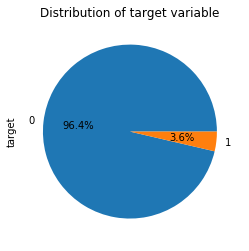

In [15]:
train['target'].value_counts().plot.pie(autopct='%1.1f%%')
plt.title('Distribution of target variable')
plt.show()

In [16]:
# 멋있게 하려면... (쓸데없어보임ㅎ)
data = [go.Bar(x=train['target'].value_counts().index.values,y=train['target'].value_counts().values, text='Distribution of target variable')]
layout = go.Layout(title='Target variable distribution')
fig = go.Figure(data=data,layout=layout)
py.iplot(fig,filename='basic-bar')

## Handling imbalanced classes
undersampling records with target = 0

In [17]:
desired_apriori = 0.10

# Get the indices per target value
idx_0 = train[train.target==0].index
idx_1 = train[train.target==1].index

# Get original number of records per target value
nb_0 = len(train.loc[idx_0])
nb_1 = len(train.loc[idx_1])

# Calculate the undersampling rate and resulting number of records with target=0
undersampling_rate = ((1-desired_apriori)*nb_1)/(nb_0*desired_apriori)
undersampled_nb_0 = int(undersampling_rate*nb_0)
print('Rate to undersample records with target=0 : {}'.format(undersampling_rate))
print('Number of records with target=0 after undersampling: {}'.format(undersampled_nb_0))

# Randomly select records with target=0 to get at the desired a priori
from sklearn.utils import shuffle

undersampled_idx = shuffle(idx_0, random_state=37, n_samples=undersampled_nb_0)

# Construct list with remaining indices
idx_list = list(undersampled_idx) + list(idx_1)

# Return undersample data frame
train = train.loc[idx_list].reset_index(drop=True)

Rate to undersample records with target=0 : 0.34043569687437886
Number of records with target=0 after undersampling: 195246


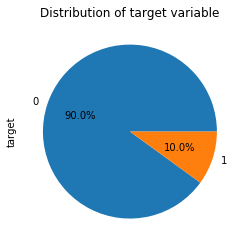

In [18]:
train['target'].value_counts().plot.pie(autopct='%1.1f%%')
plt.title('Distribution of target variable')
plt.show()

## Data Quality Check
Checking missing values

In [19]:
train.isnull().any().any()

False

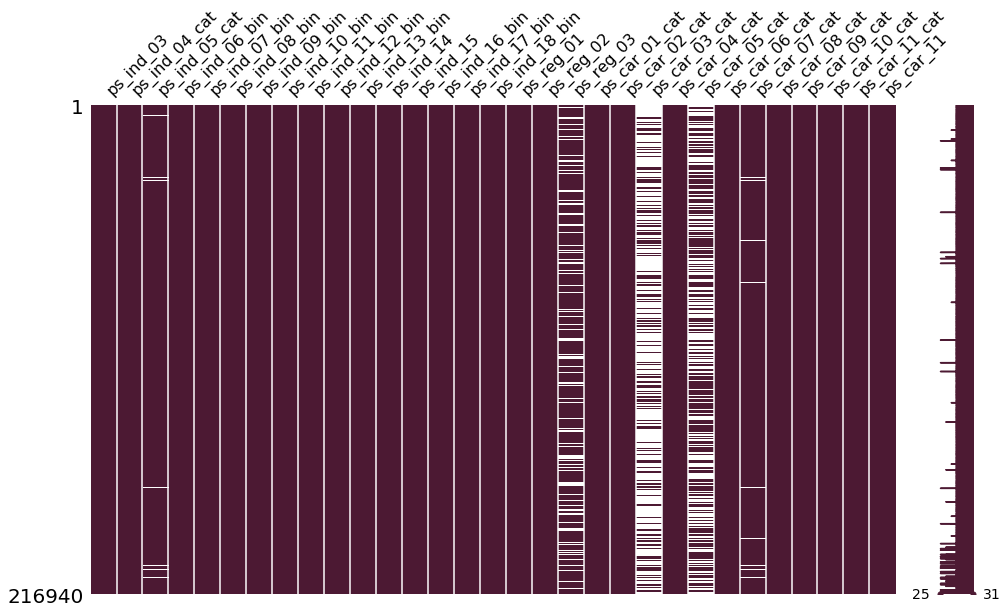

In [20]:
train_check_null = train
train_check_null = train_check_null.replace(-1,np.NaN)

import missingno as msno
msno.matrix(train_check_null.iloc[:,4:35],figsize=(16,9),color=(0.3,0.1,0.2))

In [21]:

missing_col = []
for c in train_check_null.columns:
    if train_check_null[c].isnull().sum() > 0:
        missing_col.append(c)
        print('col : {:<15}, Nan records : {:>6}, Nan ratio : {:.3f}'.format(c, train_check_null[c].isnull().sum(), 100*(train_check_null[c].isnull().sum()/train_check_null[c].shape[0])))

col : ps_ind_02_cat  , Nan records :    103, Nan ratio : 0.047
col : ps_ind_04_cat  , Nan records :     51, Nan ratio : 0.024
col : ps_ind_05_cat  , Nan records :   2256, Nan ratio : 1.040
col : ps_reg_03      , Nan records :  38580, Nan ratio : 17.784
col : ps_car_01_cat  , Nan records :     62, Nan ratio : 0.029
col : ps_car_02_cat  , Nan records :      2, Nan ratio : 0.001
col : ps_car_03_cat  , Nan records : 148367, Nan ratio : 68.391
col : ps_car_05_cat  , Nan records :  96026, Nan ratio : 44.264
col : ps_car_07_cat  , Nan records :   4431, Nan ratio : 2.043
col : ps_car_09_cat  , Nan records :    230, Nan ratio : 0.106
col : ps_car_11      , Nan records :      1, Nan ratio : 0.000
col : ps_car_14      , Nan records :  15726, Nan ratio : 7.249


In [22]:
meta.loc[missing_col,'level']

varname
ps_ind_02_cat     nominal
ps_ind_04_cat     nominal
ps_ind_05_cat     nominal
ps_reg_03        interval
ps_car_01_cat     nominal
ps_car_02_cat     nominal
ps_car_03_cat     nominal
ps_car_05_cat     nominal
ps_car_07_cat     nominal
ps_car_09_cat     nominal
ps_car_11         ordinal
ps_car_14        interval
Name: level, dtype: object

ps_car_03_cat , ps_car_05_cat : 결측치가 너무 많음 --> 제거  
ps_reg_03,ps_car_14 : interval  --> 분포 보고 결정  
ps_car_11 : ordinal  --> 최빈값  
나머지 : nominal --> 최빈값

In [23]:
# dropping the variables
train.drop(['ps_car_03_cat','ps_car_05_cat'],inplace=True, axis=1)
# updating the meta
meta.loc[['ps_car_03_cat','ps_car_05_cat'],'keep']=False

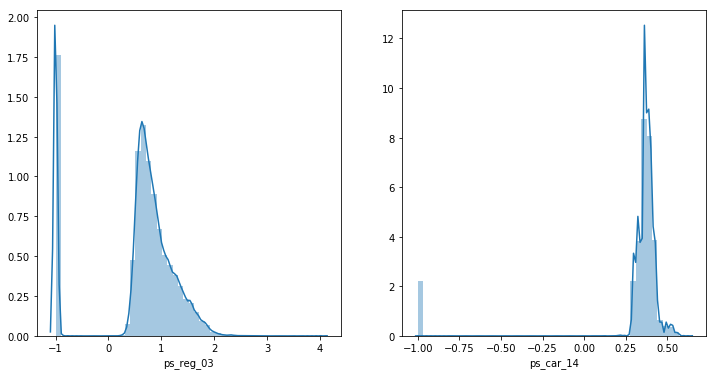

In [24]:
f,ax = plt.subplots(1,2,figsize=(12,6))

sns.distplot(train['ps_reg_03'],ax=ax[0])
sns.distplot(train['ps_car_14'],ax=ax[1])

In [25]:
# Imputing with the mean or mode
mean_imp = Imputer(missing_values=-1,strategy='mean',axis=0)
mode_imp = Imputer(missing_values=-1, strategy='most_frequent', axis=0)
train['ps_reg_03'] = mean_imp.fit_transform(train[['ps_reg_03']]).ravel()
train['ps_car_14'] = mean_imp.fit_transform(train[['ps_car_14']]).ravel()

In [26]:
tmp = ['ps_car_01_cat','ps_car_02_cat',
       'ps_car_07_cat','ps_car_09_cat']

train['ps_car_11'] = mode_imp.fit_transform(train[['ps_car_11']]).ravel()
train['ps_ind_02_cat'] = mode_imp.fit_transform(train[['ps_ind_02_cat']]).ravel()
train['ps_ind_04_cat'] = mode_imp.fit_transform(train[['ps_ind_04_cat']]).ravel()
train['ps_ind_05_cat'] = mode_imp.fit_transform(train[['ps_ind_05_cat']]).ravel()

for c in tmp:
    train[c] = mode_imp.fit_transform(train[[c]]).ravel()



# Serires.ravel(order='C') 
# Return the flattened underlying data as an ndarray. 
# so, the ps_reg_03 column case : (216940, 1) --> (216940,)

## Checking the cardinality of the categorical variables

In [27]:
v = meta[(meta.level=='nominal')&(meta.keep)].index

for f in v:
    dist_values = train[f].value_counts().shape[0] # == nuique() 
    print('col:{:<10}   distinct values count:{}'.format(f,dist_values))

col:ps_ind_02_cat   distinct values count:4
col:ps_ind_04_cat   distinct values count:2
col:ps_ind_05_cat   distinct values count:7
col:ps_car_01_cat   distinct values count:12
col:ps_car_02_cat   distinct values count:2
col:ps_car_04_cat   distinct values count:10
col:ps_car_06_cat   distinct values count:18
col:ps_car_07_cat   distinct values count:2
col:ps_car_08_cat   distinct values count:2
col:ps_car_09_cat   distinct values count:5
col:ps_car_10_cat   distinct values count:3
col:ps_car_11_cat   distinct values count:104


## Target encoding for categorical features


Bert Carremans do below job(target encoding) but i won't. I will transform values using dummy variables.

In [ ]:
# Script by https://www.kaggle.com/ogrellier
# Code: https://www.kaggle.com/ogrellier/python-target-encoding-for-categorical-features
def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))

def target_encode(trn_series=None, 
                  tst_series=None, 
                  target=None, 
                  min_samples_leaf=1, 
                  smoothing=1,
                  noise_level=0):
    """
    Smoothing is computed like in the following paper by Daniele Micci-Barreca
    https://kaggle2.blob.core.windows.net/forum-message-attachments/225952/7441/high%20cardinality%20categoricals.pdf
    trn_series : training categorical feature as a pd.Series
    tst_series : test categorical feature as a pd.Series
    target : target data as a pd.Series
    min_samples_leaf (int) : minimum samples to take category average into account
    smoothing (int) : smoothing effect to balance categorical average vs prior  
    """ 
    assert len(trn_series) == len(target)
    assert trn_series.name == tst_series.name
    temp = pd.concat([trn_series, target], axis=1)
    # Compute target mean #agg = aggregate(func_or_funcs)
    averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
    # Compute smoothing
    smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
    # Apply average function to all target data
    prior = target.mean()
    # The bigger the count the less full_avg is taken into account
    averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
    averages.drop(["mean", "count"], axis=1, inplace=True)
    # Apply averages to trn and tst series
    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=trn_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_trn_series.index = trn_series.index 
    ft_tst_series = pd.merge(
        tst_series.to_frame(tst_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=tst_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_tst_series.index = tst_series.index
    return add_noise(ft_trn_series, noise_level), add_noise(ft_tst_series, noise_level)

In [ ]:
train_encoded, test_encoded = target_encode(train["ps_car_11_cat"], 
                             test["ps_car_11_cat"], 
                             target=train.target, 
                             min_samples_leaf=100,
                             smoothing=10,
                             noise_level=0.01)

In [ ]:
train_encoded.head()

In [ ]:
train['ps_car_11_cat_te'] = train_encoded
train.drop('ps_car_11_cat', axis=1, inplace=True)
meta.loc['ps_car_11_cat','keep'] = False  # Updating the meta
test['ps_car_11_cat_te'] = test_encoded
test.drop('ps_car_11_cat', axis=1, inplace=True)

In [28]:
# if you use one-hot encoding
# xx = train['ps_ind_02_cat'].values.reshape(-1,1)
# xx = ohe.fit_transform(xx).toarray()
# tt = pd.concat([train.drop('ps_ind_02_cat',axis=1,inplace=True), pd.DataFrame(xx)],axis=1)

# I'll create dummy variables
for col in v:
    train = pd.concat([train.drop(col,axis=1),pd.get_dummies(train[col], prefix='dum_'+col)],axis=1)

In [29]:
train[ 'dum_ps_car_11_cat_104']

0         0
1         1
2         0
3         0
4         0
5         0
6         0
7         0
8         0
9         0
10        0
11        0
12        0
13        0
14        0
15        0
16        0
17        1
18        1
19        0
20        0
21        0
22        0
23        0
24        1
25        0
26        0
27        0
28        0
29        0
         ..
216910    0
216911    1
216912    0
216913    0
216914    0
216915    0
216916    0
216917    0
216918    1
216919    0
216920    0
216921    0
216922    0
216923    0
216924    0
216925    1
216926    1
216927    0
216928    0
216929    0
216930    0
216931    0
216932    0
216933    0
216934    0
216935    1
216936    0
216937    1
216938    1
216939    0
Name: dum_ps_car_11_cat_104, Length: 216940, dtype: uint8

## RandomForest 

Using RandomForest without changing the default.

In [30]:
X_train = train.drop(['id','target'],axis=1)
y_train = train.target

rf = RandomForestClassifier(n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [31]:
rf.score(X_train, y_train)

0.9810731077717341

In [32]:
# create metadata table

data = []
for f in test.columns:
    # Defining the role
    if f == 'target':
        role = 'target'
    elif f == 'id':
        role = 'id'
    else:
        role = 'input'
        
    # Defining the level
    if 'bin' in f or f == 'target':
        level = 'binary'
    elif 'cat' in f or f =='id':
        level = 'nominal'
    elif test[f].dtype == float:
        level = 'interval'
    elif test[f].dtype == int:
        level = 'ordinal'
        
    # Initialize keep to True for all variables except for id
    keep = True
    if f == 'id':
        keep = False
        
    # Defining the data type
    dtype = test[f].dtype
    
    # Creating a Dcit that contains all the meta_test_testdata for the variable
    f_dict = {
        'varname':f,
        'role':role,
        'level':level,
        'keep':keep,
        'dtype':dtype
    }
    data.append(f_dict)
    
meta_test = pd.DataFrame(data, columns=['varname','role','level','keep','dtype'])
meta_test.set_index('varname',inplace=True)    

In [33]:
# Imputing or drop on missing columns
test_check_null = test
test_check_null = test_check_null.replace(-1,np.NaN)

missing_col_test = []
for c in test_check_null.columns:
    if test_check_null[c].isnull().sum() > 0:
        missing_col_test.append(c)
        print('col : {:<15}, Nan records : {:>6}, Nan ratio : {:.3f}'.format(c, test_check_null[c].isnull().sum(), 100*(test_check_null[c].isnull().sum()/test_check_null[c].shape[0])))

col : ps_ind_02_cat  , Nan records :    307, Nan ratio : 0.034
col : ps_ind_04_cat  , Nan records :    145, Nan ratio : 0.016
col : ps_ind_05_cat  , Nan records :   8710, Nan ratio : 0.976
col : ps_reg_03      , Nan records : 161684, Nan ratio : 18.109
col : ps_car_01_cat  , Nan records :    160, Nan ratio : 0.018
col : ps_car_02_cat  , Nan records :      5, Nan ratio : 0.001
col : ps_car_03_cat  , Nan records : 616911, Nan ratio : 69.097
col : ps_car_05_cat  , Nan records : 400359, Nan ratio : 44.842
col : ps_car_07_cat  , Nan records :  17331, Nan ratio : 1.941
col : ps_car_09_cat  , Nan records :    877, Nan ratio : 0.098
col : ps_car_11      , Nan records :      1, Nan ratio : 0.000
col : ps_car_14      , Nan records :  63805, Nan ratio : 7.146


In [34]:
missing_col == missing_col_test

True

Luckly, missing value occurs in the same columns.

In [35]:
# dropping the variables
test.drop(['ps_car_03_cat','ps_car_05_cat'],inplace=True, axis=1)
# updating the meta
meta_test.loc[['ps_car_03_cat','ps_car_05_cat'],'keep']=False

# Imputing values - mean
test['ps_reg_03'] = mean_imp.fit_transform(test[['ps_reg_03']]).ravel()
test['ps_car_14'] = mean_imp.fit_transform(test[['ps_car_14']]).ravel()

# Imputing values - mode
tmp = ['ps_car_01_cat','ps_car_02_cat','ps_car_11','ps_ind_02_cat',
       'ps_car_07_cat','ps_car_09_cat','ps_ind_04_cat','ps_ind_05_cat']

for c in tmp:
    test[c] = mode_imp.fit_transform(test[[c]]).ravel()

In [36]:
# create dummy variables
v = meta_test[(meta_test.level=='nominal')&(meta_test.keep)].index

for f in v:
    dist_values = test[f].value_counts().shape[0] # == nuique() 
    print('col:{:<10}   distinct values count:{}'.format(f,dist_values))

col:ps_ind_02_cat   distinct values count:4
col:ps_ind_04_cat   distinct values count:2
col:ps_ind_05_cat   distinct values count:7
col:ps_car_01_cat   distinct values count:12
col:ps_car_02_cat   distinct values count:2
col:ps_car_04_cat   distinct values count:10
col:ps_car_06_cat   distinct values count:18
col:ps_car_07_cat   distinct values count:2
col:ps_car_08_cat   distinct values count:2
col:ps_car_09_cat   distinct values count:5
col:ps_car_10_cat   distinct values count:3
col:ps_car_11_cat   distinct values count:104


In [37]:
# I'll create dummy variables
for col in v:
    test = pd.concat([test.drop(col,axis=1),pd.get_dummies(test[col], prefix='dum_'+col)],axis=1)

In [38]:
test.head(2)

,id,ps_ind_01,ps_ind_03,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,...,dum_ps_car_11_cat_65,dum_ps_car_11_cat_66,dum_ps_car_11_cat_67,dum_ps_car_11_cat_68,dum_ps_car_11_cat_69,dum_ps_car_11_cat_70,dum_ps_car_11_cat_71,dum_ps_car_11_cat_72,dum_ps_car_11_cat_73,dum_ps_car_11_cat_74,dum_ps_car_11_cat_75,dum_ps_car_11_cat_76,dum_ps_car_11_cat_77,dum_ps_car_11_cat_78,dum_ps_car_11_cat_79,dum_ps_car_11_cat_80,dum_ps_car_11_cat_81,dum_ps_car_11_cat_82,dum_ps_car_11_cat_83,dum_ps_car_11_cat_84,dum_ps_car_11_cat_85,dum_ps_car_11_cat_86,dum_ps_car_11_cat_87,dum_ps_car_11_cat_88,dum_ps_car_11_cat_89,dum_ps_car_11_cat_90,dum_ps_car_11_cat_91,dum_ps_car_11_cat_92,dum_ps_car_11_cat_93,dum_ps_car_11_cat_94,dum_ps_car_11_cat_95,dum_ps_car_11_cat_96,dum_ps_car_11_cat_97,dum_ps_car_11_cat_98,dum_ps_car_11_cat_99,dum_ps_car_11_cat_100,dum_ps_car_11_cat_101,dum_ps_car_11_cat_102,dum_ps_car_11_cat_103,dum_ps_car_11_cat_104
0,0,0,8,0,1,0,0,0,0,0,0,0,12,1,0,0,0.5,0.3,0.610328,1.0,0.316228,0.669556,0.352136,3.464102,0.1,0.8,0.6,1,1,6,3,6,2,9,1,1,1,12,0,1,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,4,5,0,0,0,1,0,0,0,0,0,5,1,0,0,0.9,0.5,0.771362,1.0,0.316228,0.606320,0.358329,2.828427,0.4,0.5,0.4,3,3,8,4,10,2,7,2,0,3,10,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [39]:
X_test = test.drop('id',axis=1)

predicted = rf.predict_proba(X_test)

In [ ]:
def gini(actual, pred, cmpcol = 0, sortcol = 1):  
    assert( len(actual) == len(pred) )  
    all = np.asarray(np.c_[ actual, pred, np.arange(len(actual)) ], dtype=np.float)  
    all = all[ np.lexsort((all[:,2], -1*all[:,1])) ]  
    totalLosses = all[:,0].sum()  
    giniSum = all[:,0].cumsum().sum() / totalLosses  
    giniSum -= (len(actual) + 1) / 2.  
    return giniSum / len(actual)  

    def gini_normalized(a, p):  
        return gini(a, p) / gini(a, a)  
    
    def test_gini():
        def fequ(a,b):  
            return abs( a -b) < 1e-6  
        def T(a, p, g, n):  
            assert( fequ(gini(a,p), g) )  
            assert( fequ(gini_normalized(a,p), n) )  
        T([1, 2, 3], [10, 20, 30], 0.111111, 1)  
        T([1, 2, 3], [30, 20, 10], -0.111111, -1)  
        T([1, 2, 3], [0, 0, 0], -0.111111, -1)  
        T([3, 2, 1], [0, 0, 0], 0.111111, 1)  
        T([1, 2, 4, 3], [0, 0, 0, 0], -0.1, -0.8)  
        T([2, 1, 4, 3], [0, 0, 2, 1], 0.125, 1)  
        T([0, 20, 40, 0, 10], [40, 40, 10, 5, 5], 0, 0)  
        T([40, 0, 20, 0, 10], [1000000, 40, 40, 5, 5], 0.171428,0.6)  
        T([40, 20, 10, 0, 0], [40, 20, 10, 0, 0], 0.285714, 1)  
        T([1, 1, 0, 1], [0.86, 0.26, 0.52, 0.32], -0.041666, -0.333333)

In [ ]:
# gini(y_train,predicted)
# print(len(y_train),len(predicted))

In [42]:
submission = pd.DataFrame({'id':test['id'], 'target':pd.DataFrame(predicted)[1]})
submission.head(2)

,id,target
0,0,0.1
1,1,0.1


In [47]:
submission.to_csv('../submission.csv',index=False)

In [49]:
pd.read_csv('../submission.csv').head()

,id,target
0,0,0.1
1,1,0.1
2,2,0.1
3,3,0.2
4,4,0.1


In [52]:
import os
os.listdir('../')

['input', 'config', 'working', 'submission.csv', 'lib']

In [ ]:
# from sklearn.metrics import accuracy_score

# predicted = rf.predict(X_test)
# accuracy = accuracy_score(y_test, predicted)

# print(f'Out-of-bag score estimate: {rf.oob_score_:.3}')
# print(f'Mean accuracy score: {accuracy:.3}')

## Exploratory Data Visualization

In [ ]:
v = meta[(meta.level=='nominal')&(meta.keep)].index

for f in v:
    plt.figure()
    fig,ax = plt.subplots(figsize=(20,10))
    # Calculate the percentage of taget=1
    cat_perc = train[[f,'target']].groupby([f],as_index=False).mean()
    cat_perc.sort_values(by='target',ascending=False,inplace=True)
    sns.barplot(ax=ax, x=f, y='target', data=cat_perc, order=cat_perc[f])
    plt.ylabel('% target', fontsize=18)
    plt.xlabel(f, fontsize=18)
    plt.tick_params(axis='both', which='major', labelsize=18)
    plt.show();

## Interval variables
Checking the correlations between interval variables.

In [ ]:
def corr_heatmap(v):
    correlations = train[v].corr()
    
    # Create color map ranging between two colors
    cmap = sns.diverging_palette(220,10,as_cmap=True)
    
    fig,ax = plt.subplots(figsize=(10,10))
    sns.heatmap(correlations,cmap=cmap,vmax=1.0,center=0,fmt='.2f',square=True,
               linewidths=.5, annot=True, cbar_kws={'shrink':.75})
    plt.show();
    
v = meta[(meta.level=='interval')&(meta.keep)].index
corr_heatmap(v)

There are a strong correlations between the variables:  
ps_reg_02 and ps_reg_03 (0.7)  
ps_car_12 and ps_car13 (0.67)  
ps_car_12 and ps_car14 (0.58)  
ps_car_13 and ps_car15 (0.67)  

In [ ]:
s = train.sample(frac=0.1)

In [ ]:
sns.lmplot(x='ps_reg_02',y='ps_reg_03',data=s,hue='target',palette='Set1',scatter_kws={'alpha':0.3})
plt.show()

In [ ]:
sns.lmplot(x='ps_car_12', y='ps_car_13', data=s, hue='target', palette='Set1', scatter_kws={'alpha':0.3})
plt.show()

In [ ]:
sns.lmplot(x='ps_car_12', y='ps_car_14', data=s, hue='target', palette='Set1', scatter_kws={'alpha':0.3})
plt.show()

In [ ]:
sns.lmplot(x='ps_car_15', y='ps_car_13', data=s, hue='target', palette='Set1', scatter_kws={'alpha':0.3})
plt.show()

Allright, so now what? How can we decide which of the correlated variables to keep? We could perform Principal Component Analysis (PCA) on the variables to reduce the dimensions. In the AllState Claims Severity Competition I made this kernel to do that. But as the number of correlated variables is rather low, we will let the model do the heavy-lifting.  


## Checking the correlations between ordinal variables

In [ ]:
v = meta[(meta.level == 'ordinal') & (meta.keep)].index
corr_heatmap(v)

For the ordinal variables we do not see many correlations. We could, on the other hand, look at how the distributions are when grouping by the target value.


## Feature engineering
Creating dummy variables  
The values of the categorical variables do not represent any order or magnitude. For instance, category 2 is not twice the value of category 1. Therefore we can create dummy variables to deal with that. We drop the first dummy variable as this information can be derived from the other dummy variables generated for the categories of the original variable.

In [ ]:
v = meta[(meta.level == 'nominal') & (meta.keep)].index
print('Before dummification we have {} variables in train'.format(train.shape[1]))
train = pd.get_dummies(train, columns=v, drop_first=True)
print('After dummification we have {} variables in train'.format(train.shape[1]))

## Creating interaction variables

## Correlation plots
열을 float과 int로 나눠서 상관관계를 보거든. 왜이렇게 하나 궁금했는데  
train_int 를 보면 대부분이 _cat 이나 _bin_ 인 범주형. boolean 타입이야.  
그래서 correlation against continous values 를 바로 계산할 수 없기때문에 따로 나눴대!

In [ ]:
train_float = train.select_dtypes(include=['float64'])
train_int = train.select_dtypes(include=['int64'])

In [ ]:
train_int.columns

In [ ]:
colormap = plt.cm.YlGnBu
plt.figure(figsize=(16,12))
plt.title('Pearson correlation of continuous features', y=1.05, size=15)
sns.heatmap(train_float.corr(), linewidths=0.1, vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

In [ ]:
data = [
    go.Heatmap(
        z= train_int.corr().values,
        x=train_int.columns.values,
        y=train_int.columns.values,
        colorscale='Viridis',
        reversescale = False,
        text = True ,
        opacity = 1.0 )
]

layout = go.Layout(
    title='Pearson Correlation of Integer-type features',
    xaxis = dict(ticks='', nticks=36),
    yaxis = dict(ticks='' ),
    width = 900, height = 700)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='labelled-heatmap')

 For classification problems, we can conveniently call Sklearn's mutual_info_classif method which measures the **dependency between two random variables** and ranges from zero (where the random variables are independent of each other) to higher values (indicate some dependency). 

In [ ]:

# mutual_info_classif(X,y) X:Feature matrix, y:Target vector
# Estimate mutual information for a discrete target variable.
# 0 : 두 변수가 독립적, higher value : 높은 종속성
# 리턴 : 각 feature와 target변수 간 상호정보
# relies on nonparametric methods based on entropy estimation from k-nearest neighbors distances
mf = mutual_info_classif(train_float.values, train.target.values, n_neighbors=3, random_state=1)
print(mf)
# low dependency !

In [ ]:
mutual_info_classif(train_int.values, train.target.values, n_neighbors=3, random_state=1)


In [ ]:
bin_col = [col for col in train.columns if '_bin' in col]
zero_list = []
one_list = []
for col in bin_col:
    zero_list.append((train[col]==0).sum())
    one_list.append((train[col]==1).sum())

In [ ]:
trace1 = go.Bar(
    x=bin_col,
    y=zero_list ,
    name='Zero count'
)
trace2 = go.Bar(
    x=bin_col,
    y=one_list,
    name='One count'
)

data = [trace1, trace2]
layout = go.Layout(
    barmode='stack',
    title='Count of 1 and 0 in binary variables'
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='stacked-bar')

## Feature importance via Random Forest


RandomForest : 
- quick
- does not require much parameter turning in obtaining useful feature importances
- pretty robust to target imbalances.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=150, max_depth=8, min_samples_leaf=4, max_features=0.2,
                           n_jobs=-1, random_state=0)
# n_estimator : 트리 갯수
# min_samples_leaf : 각 노드가 가지는 최소 샘플 수
# max_features : 값이 0.2 float이기때문에 int(max_features * n_features). split할때 고려하는 feature 수
# n_jobs : number or jobs. -1이면 전부. default 1
rf.fit(train.drop(['id','target'],axis=1), train.target)
features = train.drop(['id','target'],axis=1).columns.values
print('----Training Done----')

In [ ]:
# scatter plot
trace = go.Scatter(
    y = rf.feature_importances_,
    x = features,
    mode = 'markers',
    marker = dict(
        sizemode='diameter',
        sizeref =1,
        size=13,
        color=rf.feature_importances_,
        colorscale='Portland',
        showscale=True
    ),
    text = features
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Random Forest Feature Importance',
    hovermode= 'closest',
     xaxis= dict(
         ticklen= 5,
         showgrid=False,
        zeroline=False,
        showline=False
     ),
    yaxis=dict(
        title= 'Feature Importance',
        showgrid=False,
        zeroline=False,
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')


In [ ]:
x, y = (list(x) for x in zip(*sorted(zip(rf.feature_importances_, features), 
                                                            reverse = False)))
trace2 = go.Bar(
    x=x ,
    y=y,
    marker=dict(
        color=x,
        colorscale = 'Viridis',
        reversescale = True
    ),
    name='Random Forest Feature importance',
    orientation='h',
)

layout = dict(
    title='Barplot of Feature importances',
     width = 900, height = 2000,
    yaxis=dict(
        showgrid=False,
        showline=False,
        showticklabels=True,
#         domain=[0, 0.85],
    ))

fig1 = go.Figure(data=[trace2])
fig1['layout'].update(layout)
py.iplot(fig1, filename='plots')

## Feature importance via DecisionTree


In [ ]:
from sklearn import tree
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image,ImageDraw, ImageFont
import re

decision_tree = tree.DecisionTreeClassifier(max_depth=3)
decision_tree.fit(train.drop(['id','target'],axis=1), train.target)

# Export ourt trained model as a .dot file
with open('tree1.dot','w') as f:
    f = tree.export_graphviz(decision_tree,out_file=f,max_depth=4,impurity=False,
                             feature_names=train.drop(['id','target'],axis=1).columns.values,
                            class_names=['No','Yes'], rounded=True, filled=True)
    
# Conver .dot to .png to allow display in web notebook
check_call(['dot','-Tpng','tree1.dot','-o','tree1.png'])

# Annotating chart with PIL
img = Image.open('tree1.png')
draw = ImageDraw.Draw(img)
img.save('sample-out.png')
PImage('sample-out.png')

## Feature importance via Gradient Boosting model

Gradient Boosting proceeds in a forward stage-wise fashion,  
where at each stage regression tress are fitted on the gradient of the loss function  
(which defaults to the deviance in Sklearn implementation).

foward stage-wise : 미분가능한 손실함수의 최적화를 가능케함

In [ ]:

from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(n_estimators=100, max_depth=3, 
                               min_samples_leaf=4, max_features=0.2, random_state=0)
gb.fit(train.drop(['id', 'target'],axis=1), train.target)
features = train.drop(['id', 'target'],axis=1).columns.values
print("----- Training Done -----")

# n_estimator : The number of boosting stages to perform.
# Gradient boosting is fairly robust to over-fitting so a large number usually results in better performance.

In [ ]:
# Scatter plot 
trace = go.Scatter(
    y = gb.feature_importances_,
    x = features,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 13,
        #size= rf.feature_importances_,
        #color = np.random.randn(500), #set color equal to a variable
        color = gb.feature_importances_,
        colorscale='Portland',
        showscale=True
    ),
    text = features
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Gradient Boosting Machine Feature Importance',
    hovermode= 'closest',
     xaxis= dict(
         ticklen= 5,
         showgrid=False,
        zeroline=False,
        showline=False
     ),
    yaxis=dict(
        title= 'Feature Importance',
        showgrid=False,
        zeroline=False,
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

In [ ]:
x, y = (list(x) for x in zip(*sorted(zip(gb.feature_importances_, features), 
                                                            reverse = False)))
trace2 = go.Bar(
    x=x ,
    y=y,
    marker=dict(
        color=x,
        colorscale = 'Viridis',
        reversescale = True
    ),
    name='Gradient Boosting Classifer Feature importance',
    orientation='h',
)

layout = dict(
    title='Barplot of Feature importances',
     width = 900, height = 2000,
    yaxis=dict(
        showgrid=False,
        showline=False,
        showticklabels=True,
    ))

fig1 = go.Figure(data=[trace2])
fig1['layout'].update(layout)
py.iplot(fig1, filename='plots')